# ASPM
[Primary microcephaly-5 (MCPH5)](https://omim.org/entry/608716) is caused by homozygous or compound heterozygous mutation in the ASPM gene.
The ASPM gene encodes a protein that plays a critical role in neurogenesis, particularly in the regulation of mitotic spindle function during cell division in neural progenitor cells ([PMID: 16798874](https://pubmed.ncbi.nlm.nih.gov/16798874/)). 

Autosomal recessive primary microcephaly-5 (MCPH5) is characterized by primnary microcephaly, intellectual disability, and speech delay.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


### ASPM
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ASPM.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service

gene_symbol = 'ASPM'
mane_tx_id = 'NM_018136.5'
mane_protein_id = 'NP_060606.3' # abnormal spindle-like microcephaly-associated protein isoform 1
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

### Phenopackets
We loaded a cohort of 22 phenopackets representing published descriptions of individuals with pathogenic variants in ASPM diagnosed with MCPH5.

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.24' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals from {gene_symbol} cohort.')
qc.summarize()

Individuals Processed: 100%|██████████| 22/22 [00:00<00:00, 1591.88 individuals/s]
Loaded 22 individuals from ASPM cohort.
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
22,Microcephaly
18,Intellectual disability
16,Short stature
14,Decreased body weight
7,Hyperactivity
3,Aggressive behavior
2,Self-injurious behavior
1,Motor delay
1,Opisthotonus
1,Simplified gyral pattern


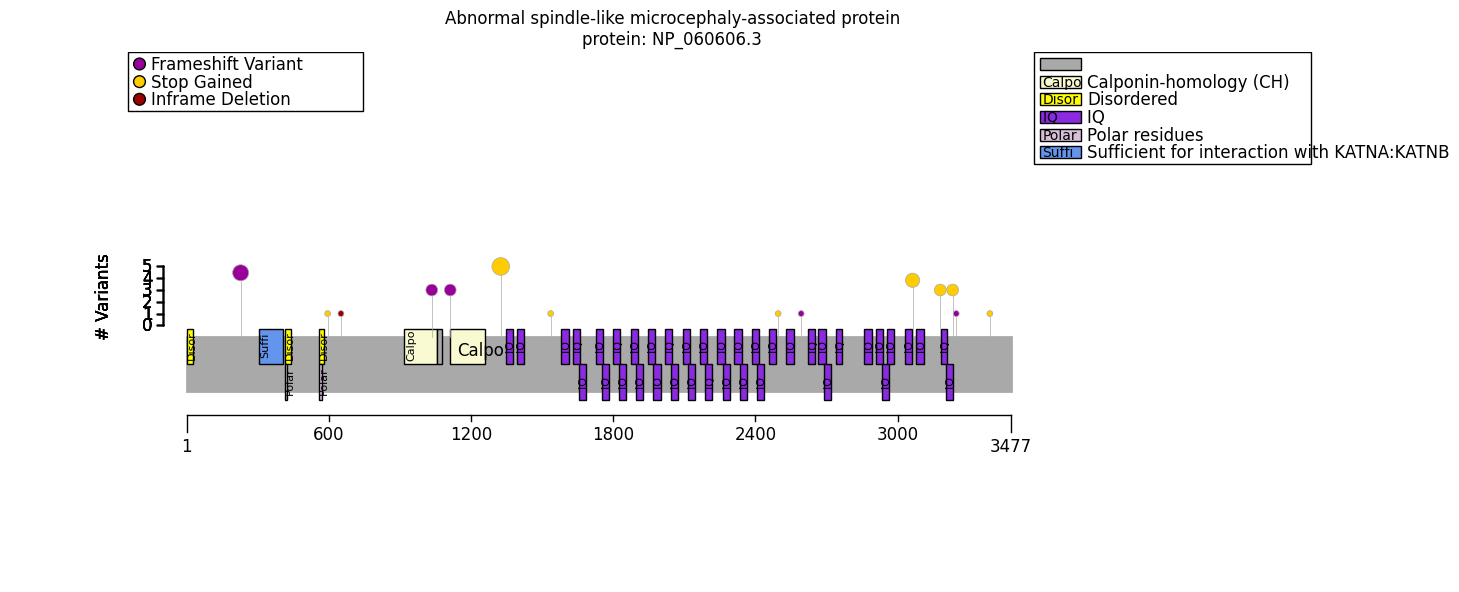

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

aspm_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
aspm_fig.tight_layout()

## Genotype-Phenotype Correlation (GPC) Analysis
We see that all published variants belong to categories such as frameshift or stop gained (nonsense) that are often considered to be loss of function variants, so there is no obvious hypothesis to make regarding correlations between different variant classes. We see that roughly half of the published variants are located N-terminal to residue 1200, so we will perform the corresponding region test.

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.model.genome import Region
from gpsea.view import MtcStatsViewer
from gpsea.analysis.predicate import protein_region
from gpsea.analysis.clf import biallelic_classifier

n_term = protein_region(region=Region(0, 1200), tx_id=mane_tx_id)
nterm_clf = biallelic_classifier(
    a_predicate=n_term,
    b_predicate=~n_term,
    a_label="N Term",
    b_label="other",
    partitions=((0,1),(2,))
)
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=nterm_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(nterm_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,5
"Skipping ""general"" level terms",19
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),48


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group,N Term/N Term OR N Term/other,other/other,Corrected p values,p values
Short stature [HP:0004322],5/8 (62%),11/14 (79%),1.0,0.624355
Decreased body weight [HP:0004325],6/8 (75%),8/14 (57%),1.0,0.649398
Hyperactivity [HP:0000752],3/7 (43%),4/13 (31%),1.0,0.651354
Seizure [HP:0001250],0/8 (0%),1/13 (8%),1.0,1.000000
Self-injurious behavior [HP:0100716],1/8 (12%),1/13 (8%),1.0,1.000000
Aggressive behavior [HP:0000718],1/8 (12%),2/13 (15%),1.0,1.000000
Growth delay [HP:0001510],5/5 (100%),11/11 (100%),1.0,1.000000
Intellectual disability [HP:0001249],7/7 (100%),11/11 (100%),1.0,1.000000
Neurodevelopmental abnormality [HP:0012759],7/7 (100%),11/11 (100%),1.0,1.000000
Microcephaly [HP:0000252],8/8 (100%),14/14 (100%),1.0,1.000000


In [9]:
from gpsea.analysis.clf import sex_classifier
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Decreased body weight [HP:0004325],11/14 (79%),3/8 (38%),0.853509,0.081459
Hyperactivity [HP:0000752],3/14 (21%),4/6 (67%),0.853509,0.121930
Aggressive behavior [HP:0000718],3/14 (21%),0/7 (0%),1.000000,0.521053
Self-injurious behavior [HP:0100716],2/14 (14%),0/7 (0%),1.000000,0.533333
Short stature [HP:0004322],11/14 (79%),5/8 (62%),1.000000,0.624355
Seizure [HP:0001250],1/14 (7%),0/7 (0%),1.000000,1.000000
Growth delay [HP:0001510],11/11 (100%),5/5 (100%),1.000000,1.000000
Intellectual disability [HP:0001249],11/11 (100%),7/7 (100%),1.000000,1.000000
Neurodevelopmental abnormality [HP:0012759],11/11 (100%),7/7 (100%),1.000000,1.000000
Microcephaly [HP:0000252],14/14 (100%),8/8 (100%),1.000000,1.000000


# Summary

No evidence was found for a genotype phenotype correlation in the ASPM gene.

In [10]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary
result_list = (
    GPAnalysisResultSummary.from_multi(
        result=nterm_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    )
)

aspm_caption = "No statistically significant results identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=result_list,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=aspm_caption)

from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
N Term/N Term OR N Term/other,other/other,14,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,14,0


In [11]:
summarizer.process_latex(report=report, protein_fig=aspm_fig)

Figure saved to ../../supplement/img/ASPM_protein_diagram-draft.pdf
Output to ../../supplement/tex/ASPM_summary_draft.tex
